In [0]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import torch.nn as nn
import torch.nn.functional as F
import torch

In [0]:
latent_dims = 2
num_epochs = 100
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

In [0]:
img_transform = transforms.Compose([
                                    transforms.ToTensor()
])

In [4]:
batch_size = 128
train_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw
Processing...
Done!


In [0]:
test_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=False, transform=img_transform)

In [0]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [0]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    c = capacity
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, padding=1, stride=2)
    self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1)
    self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
    self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = x.view(x.size(0), -1)
    x_mu = self.fc_mu(x)
    x_logvar = self.fc_logvar(x)
    return x_mu, x_logvar

In [0]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    c=capacity
    self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
    self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
    self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

  def forward(self, x):
    x = self.fc(x)
    x = x.view(x.size(0),capacity*2, 7, 7)
    x = F.relu(self.conv2(x))
    x = torch.sigmoid(self.conv1(x))
    return x

In [0]:
class VariationalAutoencoder(nn.Module):
  def __init__(self):
    super(VariationalAutoencoder, self).__init__()
    self.encoder= Encoder()
    self.decoder = Decoder()

  def forward(self,x):
    latent_mu, latent_logvar = self.encoder(x)
    latent = self.latent_sample(latent_mu, latent_logvar)
    x_recon = self.decoder(latent)
    return x_recon, latent_mu, latent_logvar
  
  def latent_sample(self, mu, logvar):
    if self.training:

      std = logvar.mul(0.5).exp()
      eps = torch.empty_like(std).normal_()
      return eps.mul(std).add_(mu)
    else:
      return mu

In [0]:
def vae_loss(recon_x, x, mu, logvar):
  recon_loss = F.binary_cross_entropy(recon_x.view(-1,784), x.view(-1, 784), reduction='sum')

  kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
  return recon_loss + variational_beta * kldivergence

In [11]:
vae = VariationalAutoencoder()
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)
num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 308357


In [12]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 100] average reconstruction error: 37475.354165
Epoch [2 / 100] average reconstruction error: 34983.853391
Epoch [3 / 100] average reconstruction error: 34597.389967
Epoch [4 / 100] average reconstruction error: 34406.053576
Epoch [5 / 100] average reconstruction error: 34264.382642
Epoch [6 / 100] average reconstruction error: 34141.793560
Epoch [7 / 100] average reconstruction error: 34055.288925
Epoch [8 / 100] average reconstruction error: 33989.685222
Epoch [9 / 100] average reconstruction error: 33924.739872
Epoch [10 / 100] average reconstruction error: 33864.698602
Epoch [11 / 100] average reconstruction error: 33816.374492
Epoch [12 / 100] average reconstruction error: 33782.395381
Epoch [13 / 100] average reconstruction error: 33741.093229
Epoch [14 / 100] average reconstruction error: 33699.788113
Epoch [15 / 100] average reconstruction error: 33657.332427
Epoch [16 / 100] average reconstruction error: 33628.355544
Epoch [17 / 100] average reconstruct

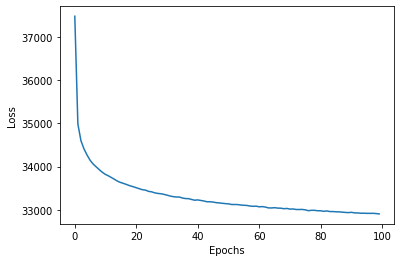

In [13]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [14]:
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
    
    with torch.no_grad():
    
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 33373.933062


Original images


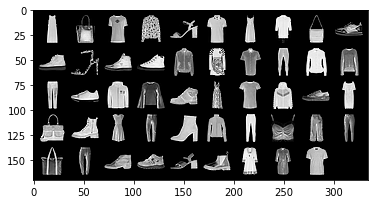

VAE reconstruction:


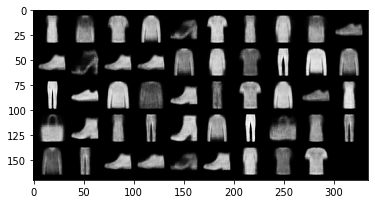

In [15]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)